In [35]:
!pip install easyocr
!pip install opencv-python-headless==4.1.2.30
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


In [36]:
import matplotlib.font_manager as fm

sys_font=fm.findSystemFonts()

nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/Nan

In [37]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [38]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4,2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image


def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)
  
  return cv_img

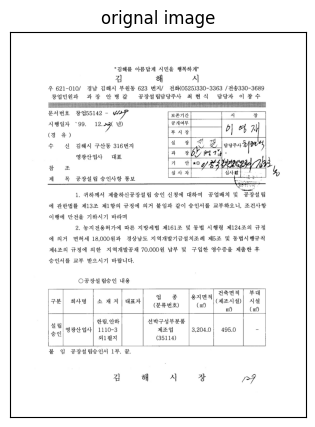

In [39]:
url = 'https://user-images.githubusercontent.com/130041317/230888356-a817ade6-beba-4b43-91e9-2b0d91012604.jpg'
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
plt_imshow("orignal image", org_image)

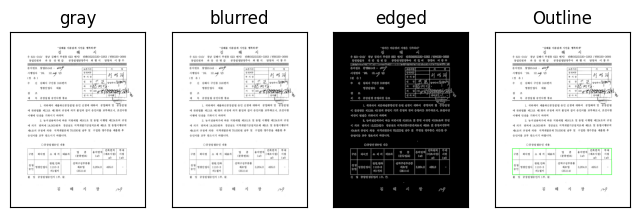

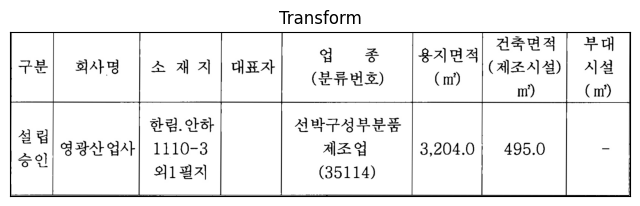

In [40]:
business_card_image = make_scan_image(org_image, width=1000, ksize=(5,5), min_threshold=20, max_threshold=100)

In [41]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(business_card_image)

[INFO] OCR'ing input image...


In [42]:
results

[([[1545, 11], [1745, 11], [1745, 72], [1545, 72]],
  '건축면적',
  0.5714275104885588),
 ([[1825, 11], [1933, 11], [1933, 73], [1825, 73]], '부대', 0.9999976397772992),
 ([[978, 42], [1188, 42], [1188, 116], [978, 116]],
  '업   종',
  0.6580472422853467),
 ([[1297, 43], [1499, 43], [1499, 111], [1297, 111]],
  '용지면적',
  0.9906306862831116),
 ([[21, 85], [127, 85], [127, 145], [21, 145]], '구분', 0.9999383818635196),
 ([[201, 81], [355, 81], [355, 149], [201, 149]], '회사명', 0.9993806648875428),
 ([[447, 83], [645, 83], [645, 147], [447, 147]],
  '소  재 지',
  0.48575228973694795),
 ([[701, 85], [851, 85], [851, 147], [701, 147]], '대표자', 0.9999113532625694),
 ([[1520, 84], [1766, 84], [1766, 146], [1520, 146]],
  '(제조시설)',
  0.5931396918233987),
 ([[1825, 83], [1930, 83], [1930, 148], [1825, 148]],
  '시설',
  0.9998642898450959),
 ([[970, 120], [1199, 120], [1199, 186], [970, 186]],
  '분류번호)',
  0.8756123069763657),
 ([[1348, 126], [1444, 126], [1444, 180], [1348, 180]],
  '(m?)',
  0.88152237927427

In [43]:
simple_results = reader.readtext(business_card_image, detail = 0)
simple_results

['건축면적',
 '부대',
 '업   종',
 '용지면적',
 '구분',
 '회사명',
 '소  재 지',
 '대표자',
 '(제조시설)',
 '시설',
 '분류번호)',
 '(m?)',
 'm)',
 '(m))',
 '한림.안하',
 '선박구성부분품',
 '설립',
 '영광산 업사',
 '1110-3',
 '제조업',
 '3,204.0',
 '495.0',
 '승인',
 '외1 필지',
 '(35114)']

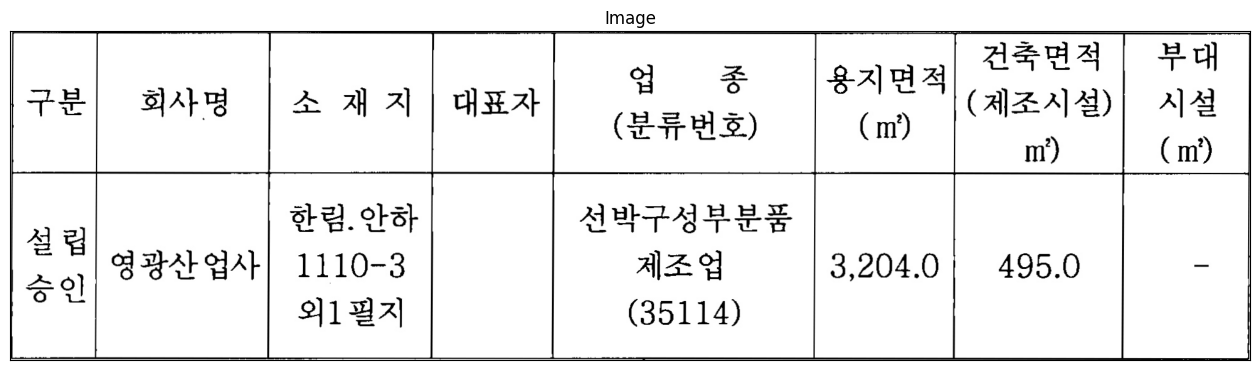

In [44]:
# show the output image
plt_imshow("Image", business_card_image, figsize=(16,10))

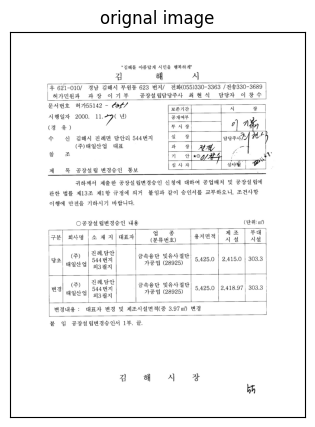

In [45]:
url = 'https://user-images.githubusercontent.com/130041317/230889661-edc80181-3031-4d2a-9c16-fd821fed7404.jpg'
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
plt_imshow("orignal image", org_image)

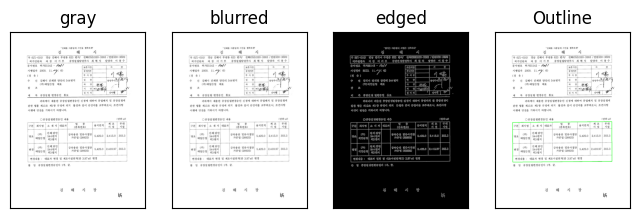

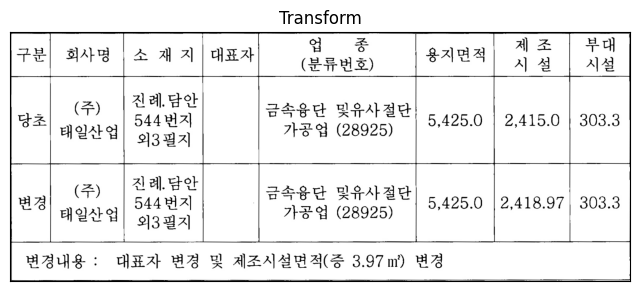

In [46]:
business_card_image = make_scan_image(org_image, width=1000, ksize=(5,5), min_threshold=20, max_threshold=100)

In [47]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(business_card_image)

[INFO] OCR'ing input image...


In [48]:
results

[([[945, 11], [1149, 11], [1149, 77], [945, 77]], '업   종', 0.7226747469384779),
 ([[1601, 11], [1731, 11], [1731, 73], [1601, 73]], '제 조', 0.9976937174797058),
 ([[1825, 11], [1933, 11], [1933, 73], [1825, 73]], '부대', 0.9999969654282558),
 ([[15, 43], [123, 43], [123, 105], [15, 105]], '구분', 0.999602578352863),
 ([[173, 43], [323, 43], [323, 107], [173, 107]], '회사명', 0.9993430205502506),
 ([[389, 43], [589, 43], [589, 105], [389, 105]],
  '소   재 지',
  0.8815180140855225),
 ([[633, 43], [783, 43], [783, 107], [633, 107]], '대표자', 0.9998942847569878),
 ([[1317, 39], [1519, 39], [1519, 107], [1317, 107]],
  '용지면적',
  0.9986099004745483),
 ([[943, 73], [1165, 73], [1165, 137], [943, 137]],
  '분류번호)',
  0.944769330417292),
 ([[1597, 71], [1729, 71], [1729, 135], [1597, 135]],
  '시 설',
  0.9688853128524674),
 ([[1825, 73], [1931, 73], [1931, 135], [1825, 135]],
  '시설',
  0.9999409949219661),
 ([[197, 213], [295, 213], [295, 275], [197, 275]], '(주)', 0.9999927044989317),
 ([[383, 187], [605, 1

In [49]:
simple_results = reader.readtext(business_card_image, detail = 0)
simple_results

['업   종',
 '제 조',
 '부대',
 '구분',
 '회사명',
 '소   재 지',
 '대표자',
 '용지면적',
 '분류번호)',
 '시 설',
 '시설',
 '(주)',
 '진례. 담안',
 '금속움단   및유사 절단',
 '당초',
 '544 번지',
 '5,425.0',
 '2,415.0',
 '303.3',
 '태일산업',
 '가공업 (28925)',
 '외3 필지',
 '(주)',
 '진례 담안',
 '금속-단   및유사 절단',
 '변경',
 '544 번지',
 '5,425.0',
 '2,418.97',
 '303.3',
 '태일산업',
 '가공업 (28925)',
 '외3 필지',
 '변경내용',
 '대표자',
 '변경   및   제조시설면 적(증 3.97m)',
 '변경']

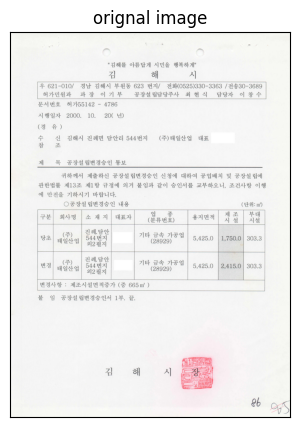

In [50]:
url = 'https://user-images.githubusercontent.com/130041317/230890227-639fe0d5-fb3c-4bd1-98f3-9c7af18f1ad8.jpg'
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
plt_imshow("orignal image", org_image)

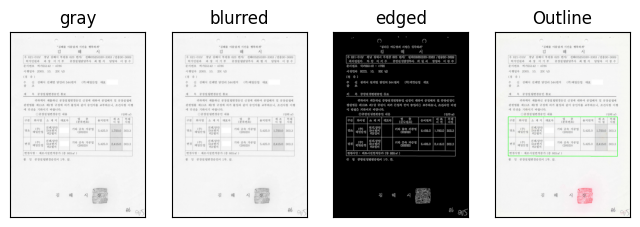

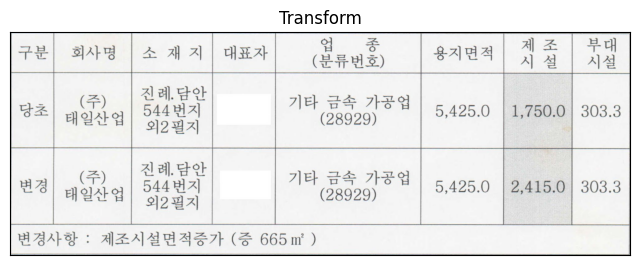

In [51]:
business_card_image = make_scan_image(org_image, width=1000, ksize=(5,5), min_threshold=20, max_threshold=100)

In [52]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(business_card_image)

[INFO] OCR'ing input image...


In [53]:
results

[([[998, 14], [1050, 14], [1050, 70], [998, 70]], '업', 0.9999177472816569),
 ([[1139, 11], [1199, 11], [1199, 71], [1139, 71]], '종', 0.9999551778093974),
 ([[21, 37], [129, 37], [129, 97], [21, 97]], '구분', 0.9999693172321554),
 ([[192, 34], [347, 34], [347, 100], [192, 100]], '회사명', 0.9995960051593208),
 ([[423, 39], [627, 39], [627, 99], [423, 99]], '소 재 지', 0.8378178478298809),
 ([[683, 39], [835, 39], [835, 95], [683, 95]], '대표자', 0.9999701986113202),
 ([[967, 65], [1217, 65], [1217, 125], [967, 125]],
  '(분류번호)',
  0.9747482051990297),
 ([[1360, 38], [1564, 38], [1564, 100], [1360, 100]],
  '용지면적',
  0.9996222257614136),
 ([[1630, 4], [1780, 4], [1780, 132], [1630, 132]], '제 절', 0.2283952683210373),
 ([[1844, 4], [1970, 4], [1970, 134], [1844, 134]],
  '부-',
  0.054022528634764755),
 ([[219, 195], [317, 195], [317, 255], [219, 255]], '(주)', 0.9951304197311401),
 ([[417, 169], [639, 169], [639, 231], [417, 231]],
  '진례 담안',
  0.972312037975171),
 ([[893, 195], [1297, 195], [1297, 25

In [54]:
simple_results = reader.readtext(business_card_image, detail = 0)
simple_results

['업',
 '종',
 '구분',
 '회사명',
 '소 재 지',
 '대표자',
 '(분류번호)',
 '용지면적',
 '제 절',
 '부-',
 '(주)',
 '진례 담안',
 '기타   금속   가공업',
 '당초',
 '544 번지',
 '5,425.0',
 '1,750.0',
 '303.3',
 '태일산업',
 '(28929)',
 '외2 필지',
 '(주)',
 '진례 담안',
 '기타   금속   가공업',
 '변경',
 '544 번지',
 '5,425.0',
 '2,415.0',
 '303.3',
 '태일산업',
 '(28929)',
 '외2 필지',
 '변경사항',
 '제조시설면 적증가 (증 665 m?']